In [ ]:
#to moun the google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#TO import data from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
#to authenticate google drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


KeyboardInterrupt: ignored

In [ ]:
#Bring file in /content/ from google drive
#https://drive.google.com/open?id=1lZYdxyO5pFFHvjxdFtGA8m9WS9haUHG5
#https://drive.google.com/open?id=1a3p1KL3egwoR76t90PaMdtszh_USRoPq
downloaded = drive.CreateFile({'id':"17yK0Igt-9G8o4iIuXxw8UeQHfPx0cJGs"})   # replace the id with id of file you want to access
#https://drive.google.com/file/d/17yK0Igt-9G8o4iIuXxw8UeQHfPx0cJGs/view?usp=sharing
downloaded.GetContentFile('Data.zip')        # replace the file name with your file

In [ ]:

#Unzipping the files
!unzip -q "/content/Data.zip"

replace Data/Test/0% Rotten/apple_102.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Yes
replace Data/Test/0% Rotten/apple_109.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


In [ ]:

#Importing libraries
import matplotlib.pyplot as plt   #for ploting
import numpy as np                #for arrays
import torch                      #for definig neural network
from torch import nn              #for definign NN
from torch import optim           #for defining optimizer
from torchsummary import summary  #for model summary
import torch.nn.functional as F   #for 
from torchvision import datasets, transforms, models  #for downloading models
import torchvision.models as models   #for downlaoding models
from PIL import Image         #for manipulating image 
from matplotlib.ticker import FormatStrFormatter #for Ploting
import os      

In [ ]:
# Tansform with data augmentation and normalization for training
# Just normalization for validation
# Training transform includes random rotation and flip to build a more robust model

#definig augmentation for train data RESIZING ROTATING FLIP CONVERTING TO TENSOR AND NORMALIZATION

train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#transform for valid data RESIZE CONVERTING TO TENSOR NORMALIZATIOM
valid_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#transform for test data RESIZE CONVERTING TO TENSOR NORMALIZATIOM
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_dir = '/content/Data/Train'
test_dir = '/content/Data/Test'

batch_size=64
#no of images feed to the network at one time

#Loading Dataset
dataset = datasets.ImageFolder(train_dir,transform=train_transforms)
testdataset = datasets.ImageFolder(test_dir,transform=test_transforms)
# splitting our dataset into Train and Validation Dataset
valid_size  = int(0.1 * len(dataset))
train_size = len(dataset) - valid_size
dataset_sizes = {'train': train_size, 'valid': valid_size}

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# Loading datasets into dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=True)

print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Valid: ",len(valid_dataset))
print("Number of Samples in Test: ",len(testdataset))
print("Total: ",len(testdataset)+len(valid_dataset)+len(train_dataset))

print("Number of Classes: ",len(testdataset.classes))

print(dataset.classes)

Number of Samples in Train:  585
Number of Samples in Valid:  65
Number of Samples in Test:  150
Total:  800
Number of Classes:  5
['0% Rotten', '100% Rotten', '25% Rotten', '50% Rotten', '75% Rotten']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#loading pre define ResNet model 
model = models.resnet34(pretrained=True)
#****************CHANGING THE OUTPUT LAYER A/C to our requirement*********************
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model = model.to(device)


summary(model, input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [ ]:
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to(device)

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [ ]:
epochs = 50
steps = 0
print_every = 10

#for ploting Graphs
valid_loss_A = []
valid_accuracy_A= []
train_loss_A= []

#change to gpu mode
model.to(device)
model.train()

for e in range(epochs):
    print("Starting Epoch",e+1)
    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            ValidLoss = round(valid_loss/len(validloader),3)
            ValidAccuracy = round(float(accuracy/len(validloader)),3)
            TrainingLoss = round(running_loss/print_every,3)
            print("No. epochs:",(e+1),"\tTraining Loss:",TrainingLoss,"\tValid Loss",ValidLoss,"\tValid Accuracy",ValidAccuracy)
            
            valid_loss_A.append(ValidLoss)
            valid_accuracy_A.append(ValidAccuracy)
            train_loss_A.append(TrainingLoss)


            if (e+1)  == epochs :
              #Saving: feature weights, new model.fc, index-to-class mapping, optimiser state, and No. of epochs
              checkpoint = {
              'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': dataset.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}
              #name = str(e)
              path = '/content/drive/My Drive/Colab Notebooks/model/modelFinal.pth'
              torch.save(checkpoint, path)

            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

Starting Epoch 1


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


No. epochs: 1 	Training Loss: 1.429 	Valid Loss 0.682 	Valid Accuracy 0.828
Starting Epoch 2
No. epochs: 2 	Training Loss: 0.873 	Valid Loss 0.541 	Valid Accuracy 0.781
Starting Epoch 3
No. epochs: 3 	Training Loss: 0.725 	Valid Loss 0.737 	Valid Accuracy 0.797
Starting Epoch 4
No. epochs: 4 	Training Loss: 0.753 	Valid Loss 0.788 	Valid Accuracy 0.805
Starting Epoch 5
No. epochs: 5 	Training Loss: 0.706 	Valid Loss 0.903 	Valid Accuracy 0.836
Starting Epoch 6
No. epochs: 6 	Training Loss: 0.59 	Valid Loss 0.513 	Valid Accuracy 0.797
Starting Epoch 7
No. epochs: 7 	Training Loss: 0.388 	Valid Loss 1.124 	Valid Accuracy 0.344
Starting Epoch 8
No. epochs: 8 	Training Loss: 0.392 	Valid Loss 0.57 	Valid Accuracy 0.836
Starting Epoch 9
No. epochs: 9 	Training Loss: 0.339 	Valid Loss 0.607 	Valid Accuracy 0.844
Starting Epoch 10
No. epochs: 10 	Training Loss: 0.273 	Valid Loss 0.494 	Valid Accuracy 0.836
Starting Epoch 11
No. epochs: 11 	Training Loss: 0.322 	Valid Loss 0.449 	Valid Accurac

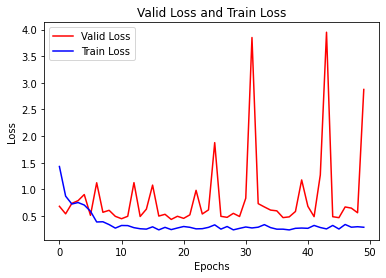

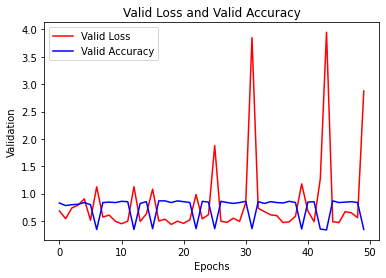

In [ ]:
epochs = range(len(valid_accuracy_A))


plt.plot(epochs, valid_loss_A, 'r', label='Valid Loss')
plt.plot(epochs, train_loss_A, 'b', label='Train Loss')
plt.title('Valid Loss and Train Loss')
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.plot(epochs, valid_loss_A, 'r', label='Valid Loss')
plt.plot(epochs, valid_accuracy_A, 'b', label='Valid Accuracy')
plt.title('Valid Loss and Valid Accuracy')
plt.ylabel('Validation') 
plt.xlabel('Epochs')
plt.legend()
plt.show()